# Further problems

## Second order boundary value problems

In a second order ODE/PDE, two conditions are required. There are three possible types of boundary conditions that may be given:

* Dirichlet conditions: The solution is specified on each boundary
* Neumann conditions: The derivative of the solution is specified on each boundary
* Cauchy conditions: The solution and derivate are both specified on one boundary

The type of conditions that can be given depend on the nature of the differential equation being solved. In some cases, boundary conditions of one type will lead to a problem that is not well-posed. Either the conditions do not give a unique solution, or they are too restrictive for any solution to be found. Partial differential equations can be classified as either hyperbolic, parabolic, or elliptic, with the classification determining the types of conditions that can be applied and the appropriate choice of finite difference scheme.

In the case of Cauchy conditions, the problem can be solved by stepping forward in time using the solution on the boundary and the first interior point. The solution on the first interior point can be found by using the condition for the derivative.

The cases where we are given conditions to imposed on two different boundaries are more tricky. In 1D problems, we have seen that the problem can be solved by setting up a matrix system of equations for each node. This approach can be generalised to higher dimensions, but it becomes challenging to implement. A toy example is provided below.

### Illustration of approach using simultaneous equations

Consider a rectangular plate, with temperature $\phi(x,y)$ described by the steady heat equation $\nabla^2\phi = 0$. The plate is maintained at boundary temperatures $\phi = 300, 400$ on pairs of opposite edges as shown. We will solve this problem using a central finite difference scheme on a (3 × 3) grid of interior points.

```{image} images/3_3_grid.png
:alt: 3x3 grid
:height: 300px
:align: center 
```

The governing equation can be discretised using a five-point stencil:

$$ \phi_{i+1,j}+\phi_{i-1,j}+\phi_{i,j+1}+\phi_{i,j-1}-4\phi_{i,j}=0$$

There is one equation for each node (equation variable), so we number the nodes sequentially $\phi_{1,...9)$ as illustrated, resulting in the following system of equations :

$$ 
\begin{bmatrix}
-4 & 1 & 0 & 1 & 0 & 0 & 0 & 0 & 0\\
1 & -4 & 1 & 0 & 1 & 0 & 0 & 0 & 0\\
0 & 1 & -4 & 0 & 0 & 1 & 0 & 0 & 0\\
1 & 0 & 0 & -4 & 1 & 0 & 1 & 0 & 0\\
0 & 1 & 0 & 1 & −4 & 1 & 0 & 1 & 0\\
0 & 0 & 1 & 0 & 1 & −4 & 0 & 0 & 1\\
0 & 0 & 0 & 1 & 0 & 0 & −4 & 1 & 0\\
0 & 0 & 0 & 0 & 1 & 0 & 1 & −4 & 1\\
0 & 0 & 0 & 0 & 0 & 1 & 0 & 1 & −4
\end{bmatrix}
\begin{bmatrix}
\phi_1\\\phi_2\\\phi_3\\\phi_4\\\phi_5\\\phi_6\\\phi_7\\\phi_8\\\phi_9
\end{bmatrix}
=
\begin{bmatrix}
-700\\-400\\-700\\-300\\0\\-300\\-700\\-400\\-700
\end{bmatrix}
$$

Notice that as a consequence of reshaping the array of node values into a column it has become slightly harder to keep track of the nodes that are neighbours. Additionally, inverting the sparse coefficient matrices can be computationally impractical for problems with many nodes. We therefore introduce an alternative, below.

### Relaxation Method

We begin by rearranging the governing finite difference formula into the form 

$$ u = F(u).$$

For instance, for the five-point formula given in the previous example, we may write

$$u_{i,j} = \frac{1}{4} (u_{i,j−1} + u{i−1,j} + u_{i+1,j} + u_{i,j+1})$$

The solution of this system can be found iteratively, by starting with a suitable initial guess for the whole field $u$ and applying the formulas until (hopefully!) a fixed solution is determined. This is known as *jacobi iteration*. To speed up convergence, the iterations can be applied sequentially to each grid-point; for example by sweeping from top-left to bottom right of the domain and updating each grid point in turn. This technique is known as the *Gauss-Seidel* relaxation method.

A less obvious improvement in the technique, known as *sucessive relaxation*, starts with the observation that in each update step we obtain a relationship of the form

$$u_{i,j}^(new) = u_{i,j}^(old) + r_{i,j},  u_{i,j}^(new) = F(u^(old))_{i,j}$$

where $r_{i,j}$ is the residual error. The proposal allows that faster convergence might be obtained by adjusting the update step in proportion to the size of the residual, which is supposed to converge to zero:

$$u_{i,j}^(new) = u_{i,j}^(old) + \gamma r_{i,j}, r_{i,j} = F(u^(old))_{i,j} − u_{i,j}^(old) $$

The relaxation parameter $\gamma$ is selected for faster convergence, with

* $\gamma$ > 1 over-relaxation,
* $\gamma$ = 1 gives the ordinary GS method, 
* $\gamma$ < 1 under-relaxation.

It is very difficult to predict the optimum value of $\gamma$, but values in the range (1, 2) typically work well.

### Example implementation of the Jacobi, Gauss-Seidel and SOR techniques in python

**Aim**: solving $u^{\prime\prime}(x) = sin(2\pi x)$ for $u(0) = u(1) = 0$

In [1]:
# Importing the relevant packages for the example
import numpy as np
from math import sin,pi, sqrt
import matplotlib.pyplot as plt
from numpy.linalg import eig, norm

In [2]:
# Setting the grid space
n = 50
x = np.linspace(0,1,n+1)
h = x[1] - x[0]

**Matrix method**

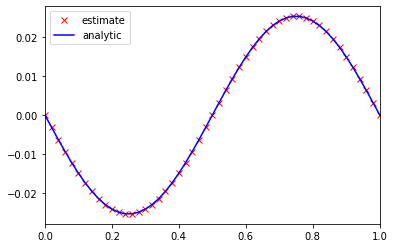

In [3]:
M = np.diag(np.insert(-2*np.ones((1,n-1))[0],(0,n-1),(1,1))) \
    + np.diag(np.append(np.ones((1,n-1))[0],0), -1) + \
        np.diag(np.insert(np.ones((1,n-1))[0],0,0),1)
k = [h**2*sin(2*pi*a) for a in x]

umatr = np.linalg.lstsq(M,k,rcond=None)

# Plot of matrix solution
plot_obj = plt.plot(x,umatr[0],'rx', x,[-sin(2*pi*a)/4/pi**2 for a in x],'b')
plt.legend(plot_obj, ('estimate','analytic'))
plt.xlim((0,1))
plt.show()

**Define the SOR parameter**
The optimum parameter for Successive Over-Relaxation (SOR) can be predicted.

In [4]:
C = np.eye(n+1) - np.linalg.lstsq(np.diag(np.diag(M)), M, rcond=None)[0]
m = max(abs(eig(C)[0]))
sor = 1+m**2/(1+sqrt(1-m**2))**2

**Iterative methods**
Let us first define the functions for the Jacobi, Gauss-Seidel and SOR algorithms. You can find them hidden below.

In [5]:
def jac(u0,k):
    # Jacobi Iteration
    u1 = np.insert((u0[2:]+u0[:-2]-np.reshape(k[1:-1],np.shape(u0[:-2])))/2, (0,len(k[1:-1])), \
        (u0[0], u0[-1]))
    
    return u1

def gsl(u0,k):
    # Gauss-Seidel iteration

    for i in range(1,len(u0)-1):
        u0[i] = (u0[i-1]+u0[i+1]-k[i])/2

    return u0

def rlx(u0,k,g):
    # Relaxation method using relaxation parameter g
    
    for i in range(1, len(u0)-1):
        u1 = (u0[i-1]+u0[i+1]-k[i])/2
        u0[i] = u0[i] + g*(u1-u0[i])

    return u0

def iterate(testfun, u0, maxit, accgoal):
    # Iterate until converged to within specified accuracy

    for counter in range(int(maxit)):
        uref = np.copy(u0)
        unext = testfun(u0)
        err = norm(unext-uref)
        if err<accgoal:
            print('converged after', counter, 'iterations')
            break
        u0 = unext
        
    return unext

In [6]:
# Initialize grid for iterative method
u0 = np.zeros((n+1,))

# Jacobi method
ujac = iterate(lambda u: (jac(u,k)),u0,1e3,1e-5)

converged after 582 iterations


In [7]:
# Gauss-Seidel
ugsl = iterate(lambda u: gsl(u,k),u0,1e3,1e-5)

converged after 366 iterations


``` {code-cell} ipython3
# Relaxation
u0 = np.zeros((n+1,))
ulrx = iterate(lambda u: rlx(u,k,sor),u0,1e3,1e-5)
```
``` {code-cell} ipython3
---
render:
    image:
        align: center
---
# Plot of relaxation solution (for example)
plot_obj = plt.plot(x,ulrx,'rx',x,[-sin(2*pi*a)/4/pi**2 for a in x],'b')
plt.legend(plot_obj, ('estimate','analytic'))
plt.xlim((0,1))
plt.show()
```